In [1]:
# Imports
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, SecondLocator, DateFormatter
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path

import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02
from aeon.analysis.utils import visits, distancetravelled


In [2]:
# Get relevant time periods

# Short, multianimal test sessions
#root = [Path("/ceph/aeon/aeon/data/raw/AEON3/multianimal-test")]

# Long, individual session
root = [Path("/ceph/aeon/aeon/data/raw/AEON2/experiment0.2")]

# Ensure root exists
if not np.all([path.exists() for path in root]):
    print("Cannot find root paths. Check path names or connection.")
subject_events = api.load(root, exp02.ExperimentalMetadata.SubjectState)

# Get > 24 hour sessions of animals starting with "BAA"
sessions = visits(subject_events[subject_events.id.str.startswith("BAA-")])
sessions = sessions[sessions.duration > pd.Timedelta("24 hours")]
display(sessions)

,id,weight_enter,weight_exit,enter,exit,duration
0,BAA-1100700,26.40,28.10,2022-02-23 14:21:25.550300121,2022-02-25 16:00:50.076419830,2 days 01:39:24.526119709
8,BAA-1100699,26.75,29.00,2022-03-29 13:11:37.277699947,2022-04-04 09:16:51.086110115,5 days 20:05:13.808410168
10,BAA-1100701,26.70,30.60,2022-04-04 15:54:07.945059776,2022-04-08 16:34:36.183650017,4 days 00:40:28.238590241
11,BAA-1100699,29.00,28.20,2022-04-20 11:51:24.997630119,2022-04-28 10:02:56.655809879,7 days 22:11:31.658179760
14,BAA-1100702,27.00,28.90,2022-05-03 11:08:12.660739899,2022-05-12 09:21:42.411650181,8 days 22:13:29.750910282
15,BAA-1100703,30.30,29.50,2022-05-25 08:59:51.050459862,2022-06-06 07:55:37.501309872,11 days 22:55:46.450850010
32,BAA-1102227,24.10,24.07,2022-08-24 12:57:30.558179855,2022-08-31 12:24:00.331900120,6 days 23:26:29.773720265
33,BAA-1102223,30.30,29.10,2022-09-26 10:37:39.908189774,2022-10-03 09:10:14.448420048,6 days 22:32:34.540230274
34,BAA-1102224,28.80,27.90,2022-10-03 11:04:29.183259964,2022-10-10 11:00:44.072539806,6 days 23:56:14.889279842


In [3]:
# Load some data

# Set time range to get data from based on one of the above "sessions"
start, end = pd.Timestamp("2022-05-25 09:00:00"), pd.Timestamp("2022-06-06 08:00:00")

# Load position data
mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
display(mouse_pos)

,x,y,angle,major,minor,area,id
time,,,,,,,
2022-05-25 09:00:00.018559933,1128.485352,377.081421,1.400470,40.002785,15.242581,632.5,0.0
2022-05-25 09:00:00.038527966,1128.333374,374.231598,1.367503,39.120983,15.174746,616.0,0.0
2022-05-25 09:00:00.058559895,1127.752686,371.373230,1.375104,38.317028,15.396613,610.0,0.0
2022-05-25 09:00:00.078527927,1127.116333,368.639618,1.366908,38.901909,15.832431,635.0,0.0
2022-05-25 09:00:00.098559856,1126.835571,366.416992,1.389153,38.970348,16.226841,649.5,0.0
...,...,...,...,...,...,...,...
2022-06-06 07:55:45.141344070,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0
2022-06-06 07:55:45.161312103,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0
2022-06-06 07:55:45.181344032,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0


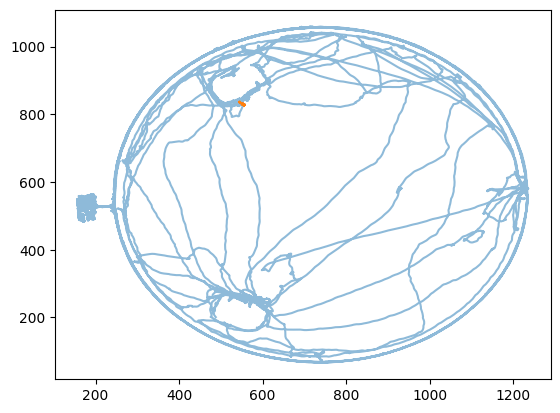

In [4]:
# Create some plots

# Plot _ hours of position activity
sub_start, sub_end = pd.Timestamp("2022-05-26 09:00:00"), pd.Timestamp("2022-05-26 10:00:00")
mouse_pos_sub = mouse_pos = api.load(root, exp02.CameraTop.Position, start=sub_start, end=sub_end)
fig, ax = plt.subplots(1, 1)
ax.plot(mouse_pos_sub.x, mouse_pos_sub.y, alpha=0.5)

# Overlay mouse position as trajectories around a few pellet deliveries
pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=sub_start, end=sub_end)
pellets_patch1 = pellets_patch1.iloc[0:5]
for pellet in pellets_patch1.itertuples():
    before = pellet.Index - pd.to_timedelta(10, 's')  # get the previous 10 seconds
    path = mouse_pos_sub.loc[before:pellet.Index]   # get position data in the time before pellet delivery
    ax.plot(path.x, path.y)

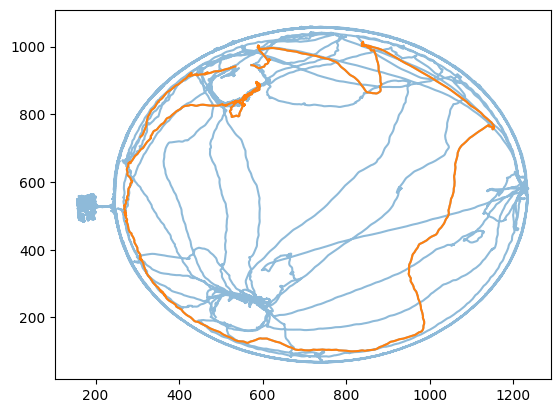

In [17]:
fig, ax = plt.subplots(1, 1)
ax.plot(mouse_pos_sub.x, mouse_pos_sub.y, alpha=0.5)
for pellet in pellets_patch1.itertuples():
    before = pellet.Index - pd.to_timedelta(100, 's')  # get the previous 10 seconds
    path = mouse_pos_sub.loc[before:pellet.Index]   # get position data in the time before pellet delivery
    ax.plot(path.x, path.y)

In [24]:
exp02.Patch2.BeamBreak

In [6]:
# Example of exporting videos

start, end = pd.Timestamp("2022-05-26 12:25:00"), pd.Timestamp("2022-05-26 12:26:00")
video_metadata = api.load(root, exp02.CameraTop.Video, start=start, end=end)
video_metadata.index = video_metadata.index.round("20L")  # round timestamps to nearest 20 ms
frames = video.frames(video_metadata)  # get actual frames based on vid metadata
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
vid = cv2.VideoWriter("mouse_foraging.mp4", fourcc=fourcc, fps=50, frameSize=(1440, 1080))  # will save to current dir
for f in frames:  # write out frames to vid, frame-by-frame
    vid.write(f)
vid.release()